# Deteccion de etiquetas

## Deteccion de etiquetas en imagenes

In [4]:
# Iniciamos las librerias
import boto3
from IPython.display import HTML, display, Image as IImage
from PIL import Image, ImageDraw, ImageFont
import time
import os

In [3]:
# Iniciamos el cliente
rekognition = boto3.client('rekognition')
s3 = boto3.client('s3')

In [5]:
# Colocamos el nombre de nuestro bucket
bucketName = "{REPLACE_YOUR_BUCKET}"
bucketName = "temporal-bucket-sm"
imageName = "deteccion-de-etiquetas/cars.png"

In [6]:
# Subimos la imagen a S3
s3.upload_file(
    Filename="recursos/cars.png",
    Bucket=bucketName,
    Key=imageName,
)

In [7]:
# Mostramos la imagen desde S3
display(IImage(url=s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': imageName})))

In [8]:
# Llamamos a la API de rekognition para detectar los objetos en la imagen
detectLabelsResponse = rekognition.detect_labels(
    Image={
        'S3Object': {
            'Bucket': bucketName,
            'Name': imageName,
        }
    }
)

In [9]:
# Mostramos el JSON retornado por la API
display(detectLabelsResponse)

{'Labels': [{'Name': 'Car',
   'Confidence': 99.87421417236328,
   'Instances': [{'BoundingBox': {'Width': 0.24012896418571472,
      'Height': 0.1800784170627594,
      'Left': 0.1865045726299286,
      'Top': 0.5646552443504333},
     'Confidence': 99.87421417236328},
    {'BoundingBox': {'Width': 0.21805639564990997,
      'Height': 0.1281619518995285,
      'Left': 0.5005310773849487,
      'Top': 0.5910496115684509},
     'Confidence': 99.79024505615234},
    {'BoundingBox': {'Width': 0.061916351318359375,
      'Height': 0.1096307560801506,
      'Left': 0.3761284351348877,
      'Top': 0.6118627786636353},
     'Confidence': 80.46967315673828}],
   'Parents': [{'Name': 'Vehicle'}, {'Name': 'Transportation'}]},
  {'Name': 'Automobile',
   'Confidence': 99.87421417236328,
   'Instances': [],
   'Parents': [{'Name': 'Vehicle'}, {'Name': 'Transportation'}]},
  {'Name': 'Vehicle',
   'Confidence': 99.87421417236328,
   'Instances': [],
   'Parents': [{'Name': 'Transportation'}]},
  {

In [10]:
flaggedObjects = ["Car"]

for label in detectLabelsResponse["Labels"]:
    if(label["Name"] in flaggedObjects):
        print("Detected unsafe object:")
        print("- {} (Confidence: {})".format(label["Name"], label["Confidence"]))
        print("  - Parents: {}".format(label["Parents"]))

Detected unsafe object:
- Car (Confidence: 99.87421417236328)
  - Parents: [{'Name': 'Vehicle'}, {'Name': 'Transportation'}]


In [14]:
def drawBoundingBoxes (sourceImage, boxes, outputImage):
    colors = ((255,255,255),(255,255,255),(76,182,252),(52,194,123))
    imageLocation = 'recursos/'+os.path.basename(sourceImage)
    bbImage = Image.open(imageLocation)
    draw = ImageDraw.Draw(bbImage)
    width, height = bbImage.size
    col = 0
    maxcol = len(colors)
    line= 3
    for box in boxes:
        x1 = int(box[1]['Left'] * width)
        y1 = int(box[1]['Top'] * height)
        x2 = int(box[1]['Left'] * width + box[1]['Width'] * width)
        y2 = int(box[1]['Top'] * height + box[1]['Height']  * height)
        
        draw.text((x1,y1),box[0],colors[col])
        for l in range(line):
            draw.rectangle((x1-l,y1-l,x2+l,y2+l),outline=colors[col])
        col = (col+1)%maxcol
    
    imageFormat = "PNG"
    ext = sourceImage.lower()
    if(ext.endswith('jpg') or ext.endswith('jpeg')):
        imageFormat = 'JPEG'

    bbImage.save(outputImage,format=imageFormat)

    display(bbImage)

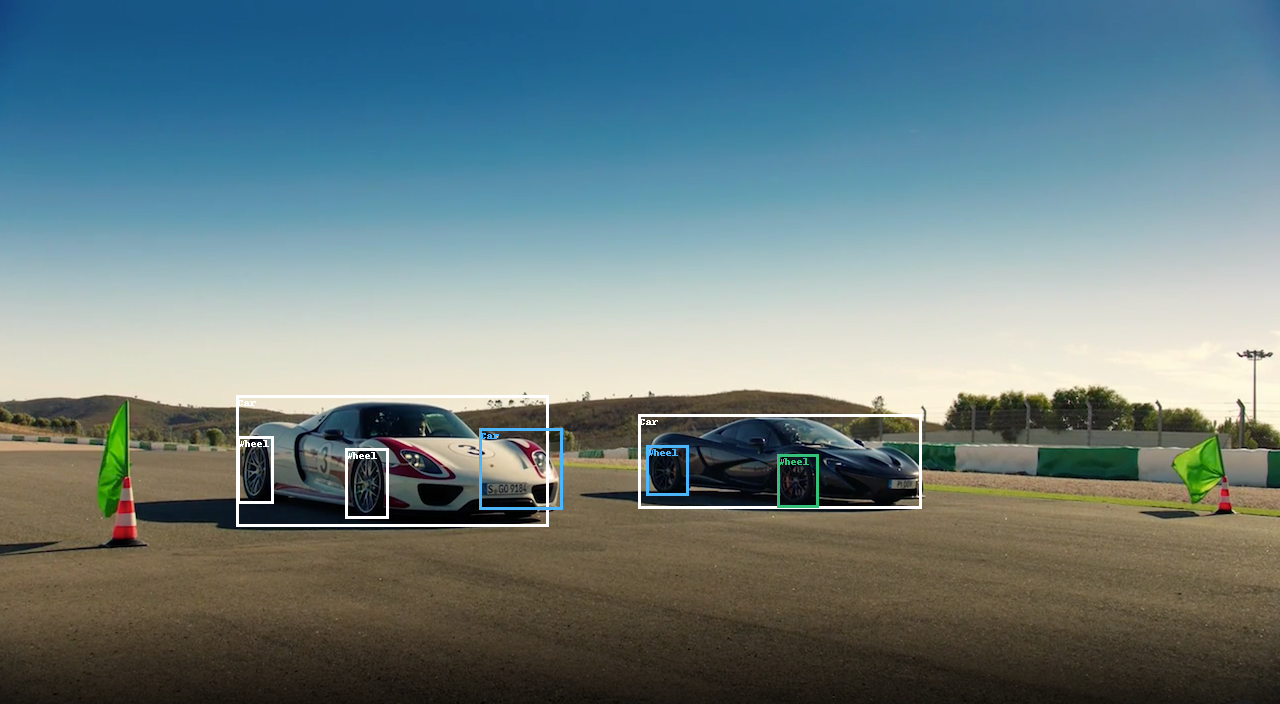

In [15]:
boxes = []
objects = detectLabelsResponse['Labels']
for obj in objects:
    for einstance in obj["Instances"]:
        boxes.append ((obj['Name'], einstance['BoundingBox']))
    
drawBoundingBoxes(imageName, boxes, 'recursos/cars2.png')